In [1]:
# [P(t+1) - P(t)] / P(t) + 1 = P(t+1) / P(t)
# ret = [P(t+1) - P(t)] / P(t)
# log_ret = log( P(t+1)/P(t) )

In [114]:
import numpy as np
import pandas as pd
import random
from pykrx import stock
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import scipy.optimize as optm
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [115]:
kospi_index = pd.read_csv('kospi_index.csv')
kospi_index['Date'] = pd.to_datetime(kospi_index['Date'])
kospi_index.set_index('Date',inplace=True)

In [116]:
price = pd.read_csv('ks200_raw_data.csv')
price = price.iloc[:,1:]
price['ticker'] = price['ticker'].astype(str).str.zfill(6)
price.set_index('Date', inplace = True)
price = price[price.index > '2014-06-10']
price = price.reset_index()

In [117]:
# 전체 날짜 1599이므로 전체날짜 있는 ticker만 남김 ( 총 143개 종목)
tmp_tf = price.groupby('ticker').count() == 1599
tmp_tf = tmp_tf.applymap(lambda x : np.nan if x == False else x).dropna()
all_date_ticker = tmp_tf.index.tolist()
tmp_price = price.set_index('ticker')

In [118]:
price = tmp_price.loc[all_date_ticker].reset_index()
price = price.sort_values(['Date','ticker'])
price = price.set_index(['Date'])
df_return = price[['ticker','ret_otc','ret','y_otc','y']]

price.drop('ret', axis=1, inplace=True)
price.drop('ret_otc', axis=1, inplace=True)
price.drop('y_otc', axis=1, inplace=True)
column_li = list(price.columns[0:-1])

In [119]:
# 통계치 계산
# 전체 covariance 계산이라 연산 오래걸림 (2분정도)
df_return['log_ret'] = np.log(df_return['ret']+1)
df_geo_mean = df_return.groupby('ticker')['log_ret'].rolling(252).sum()
df_geo_mean = df_geo_mean.reorder_levels([1, 0]).dropna() #date <-> ticker order change
df_geo_std = df_return.groupby('ticker')['log_ret'].rolling(252).std()
df_geo_std = df_geo_std.reorder_levels([1, 0]).dropna()
df_cov = df_return.pivot(columns='ticker',values='log_ret').rolling(252).cov().dropna()

In [120]:
# window를 252일(영업일 기준 1년)로 두어 rolling하며 train test 기준을 나눔
def get_rolling_DataSet(idx, lag=252, raw_data=price, datatype='array', normalize=True, ticker='all'):
    
    if ticker != 'all':
        raw_data = raw_data[raw_data['ticker'] == ticker]
        
    date_li = raw_data.index.unique()
    X_train = raw_data.loc[date_li[idx:idx+lag], column_li]
    y_train = raw_data.loc[date_li[idx:idx+lag],'y']
    X_test = raw_data.loc[date_li[idx+lag], column_li]
    y_test = raw_data.loc[date_li[idx+lag], 'y']
    ticker_li = raw_data.loc[date_li[idx+lag],'ticker']
    
    if normalize:
        scaler = StandardScaler()
        X_train.loc[:] = scaler.fit_transform(X_train)
        X_test.loc[:] = scaler.transform(X_test)
    
    if datatype == 'array':
        X_train = np.array(X_train)
        y_train = np.array(y_train).reshape((-1,1))
        X_test = np.array(X_test)
        y_test = np.array(y_test).reshape((-1,1))
        
    return X_train, y_train, X_test, y_test, ticker_li

In [121]:
# 통계치 계산
def get_score(confusion_mat):

    try :     
        accuracy  = np.diag(confusion_mat).sum()/confusion_mat.sum()
        precision = confusion_mat[1,1]/confusion_mat[:,1].sum()
        recall    = confusion_mat[1,1]/confusion_mat[1,:].sum()
        f1_score  = 2/(1/precision + 1/recall)
        sensitivity = confusion_mat[1,1]/confusion_mat[1,:].sum()
        specificity = confusion_mat[0,0]/confusion_mat[0,:].sum()
        MyScore = 2/(1/precision + 1/accuracy)
        # 오를거라고 예측한 주식  (포트폴리오에 속하게 될 주식임)
        select_num = confusion_mat[:,1].sum()
        ind = ['select_num', 'MyScore', 'accuracy', 'precision', 'recall', 'f1_score', 'sensitivity', 'specificity']

        return pd.Series([select_num, MyScore, accuracy, precision, recall,
                          f1_score, sensitivity, specificity], index=ind)
    
    except IndexError as e :
        print(e)
        accuracy  = 0
        precision = 0
        recall    = 0
        f1_score  = 0
        sensitivity = 0
        specificity = 0
        MyScore = 0
        # 오를거라고 예측한 주식  (포트폴리오에 속하게 될 주식임)
        select_num = 0
        ind = ['select_num', 'MyScore', 'accuracy', 'precision', 'recall', 'f1_score', 'sensitivity', 'specificity']
        
        return pd.Series([select_num, MyScore, accuracy, precision, recall,
                          f1_score, sensitivity, specificity], index=ind)

In [122]:
# weight 최적화 해 구하기
def optm_weight(index_list, mean, cov, std, rf) :
    bnds = tuple([(0.01, 0.3)] * len(index_list))
    cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]

    sol = optm.minimize(op_func, x0=[1/len(index_list)] * len(index_list), 
                        bounds=bnds, constraints=cons, args=(mean, cov, std, rf))
    return sol.x

In [123]:
# 포트폴리오 최적화 시 optimized function
def op_func(w, mean, cov, std, rf):
    excess_return = np.dot(w, mean) - rf
    std = np.dot(np.dot((std * w).T, cov), std * w)
    return - excess_return / std

In [124]:
# covariance,  mean, standard deviation 계산 (mean-variance optimization 하는 데 필요함)
def cal_stat(df_geo_mean, df_geo_std, df_cov, real_ticker, pred_date) :
    cov = df_cov.loc[pred_date].loc[real_ticker,real_ticker].dropna(how = 'all').dropna(how = 'all', axis=1)
    mean = df_geo_mean.loc[pred_date].loc[real_ticker].dropna()
    std = df_geo_std.loc[pred_date].loc[real_ticker].dropna()
    return cov, mean, std

In [125]:
# mean-variance optimization 계산
def mvo(df_geo_mean, df_geo_std, df_cov, real_ticker, pred_date) :
    
    (cov, mean, std) = cal_stat(df_geo_mean, df_geo_std, df_cov, real_ticker, pred_date) 
    rf = 0.005    
    weight = optm_weight(real_ticker, mean, cov, std, rf)
    
    return weight

In [126]:
# length: 예측할 날짜의 기간
# y_predict: model을 fitting하여 train하고 다음날 하루를 예측함
# ticker: 예측한 날짜의 전종목 ticker (136개)
# tmp_score: 예측한 날짜의 confusion_matrix를 통해 통계치 계산한 것 담음
# stat_df: 예측한 날짜 모두의 통계가 데이터프레임 형태로 저장되어 있음
def model_predict(model, length = 1300) :
    date_li = price.index.unique()
    score_li = []
    predict_li = []
    ticker_li = []
    confu_mat_li = []
    
    for idx in range(length): #range(len(date_li)):
        X_train, y_train, X_test, y_test, ticker = get_rolling_DataSet(idx)
        model_ = model
        model_.fit(X_train, y_train)
        y_predict = model_.predict(X_test)
        tmp_score = get_score(confusion_matrix(y_test, y_predict))
        score_li.append(tmp_score)
        predict_li.append(y_predict)
        ticker_li.append(ticker)
        confu_mat_li.append(confusion_matrix(y_test, y_predict))
        print(idx)
    
    stat_df = pd.DataFrame(score_li, index=date_li[252:252 + length])
    
    return ticker_li, date_li, predict_li, stat_df

In [127]:
# 예측한 날짜 전체의 각각 portfolio return을 계산
def cal_port_ret(ticker_li, date_li, predict_li, length = 1300): 
    port_ret_list = []
    date_list = []

    # 날짜별 portfolio return 계산
    for i in range(length) :
        # 오를거라고 예측된 주식이 하나도 없다면 밑에 과정 pass함.
        if sum(predict_li[i]) == 0 : 
            continue
            
        # 오른다고 예상된 주식 가져오기
        selected_stk = pd.DataFrame()
        selected_stk['ticker'] = ticker_li[i].tolist()
        selected_stk['predict'] = predict_li[i].tolist()
        selected_ticker_list = selected_stk[selected_stk['predict'] == 1]['ticker'].tolist()
        
        # t + 2 시점 박혀있는 수익률이 실제 얻을 수 있는 수익률
        pred_date = date_li[252 + i + 2]
        real_ticker = selected_ticker_list.copy()

        # mean-variance optimization
        weight = mvo(df_geo_mean, df_geo_std, df_cov, real_ticker, pred_date)

        # 예측할 날짜의 selected된 ticker의 수익률을 봄
        tmp_ret = df_return.reset_index()
        tmp_ret.set_index('ticker', inplace = True)
        selected_ret = tmp_ret[tmp_ret['Date'] == pred_date].loc[real_ticker]['ret']
        
        # return에 weight를 곱하여 portfolio return 계산
        port_ret = (selected_ret * weight.tolist()).sum()

        date_list.append(pred_date)
        port_ret_list.append(port_ret)
        
    return (date_list, port_ret_list)

In [128]:
# backtest할 데이터프레임 만드는 함수
def backtest(date_list, port_ret_list) :
    datetime_list = pd.to_datetime(date_list)
    backtest = pd.DataFrame()
    backtest['ret'] = port_ret_list
    backtest.index =  datetime_list

    sns.set_style('dark')
    return pd.Series(backtest['ret']), datetime_list

In [129]:
# 비교할 모델 만드는 함수 ( predict_equal & random_mvo)
def cal_port_ret_v2(ticker_li, date_li, predict_li, length = 1300) : 
    port_ret_eq_list = []
    port_ret_rand_list = []
    date_list_eq_rand = []
    
    # 날짜별 portfolio return 계산
    for i in range(length) :

        if sum(predict_li[i]) == 0 : 
            continue
        
        ### predict_equal ### 
        
        # 오른다고 예상된 주식 가져오기
        selected_stk = pd.DataFrame()
        selected_stk['ticker'] = ticker_li[i].tolist()
        selected_stk['predict'] = predict_li[i].tolist()
        selected_ticker_list = selected_stk[selected_stk['predict'] == 1]['ticker'].tolist()

        # t + 2 시점 박혀있는 수익률이 실제 얻을 수 있는 수익률
        pred_date = date_li[252 + i + 2]
        real_ticker_eq = selected_ticker_list.copy()

        tmp_ret = df_return.reset_index()
        tmp_ret.set_index('ticker', inplace = True)
        selected_ret_eq = tmp_ret[tmp_ret['Date'] == pred_date].loc[real_ticker_eq]['ret']
            
        port_ret_eq = (selected_ret_eq * 1/len(real_ticker_eq)).sum()

        date_list_eq_rand.append(pred_date)
        
    
        ### random_mvo ###
        all_ticker_list = ticker_li[0].unique().tolist()
        random_stk = random.sample(all_ticker_list, len(real_ticker_eq))
        real_ticker_rand = random_stk.copy()
        
        selected_ret_rand = tmp_ret[tmp_ret['Date'] == pred_date].loc[real_ticker_rand]['ret']
        port_ret_rand = (selected_ret_rand * 1/len(real_ticker_rand)).sum()

        port_ret_eq_list.append(port_ret_eq)
        port_ret_rand_list.append(port_ret_rand)
        print(i)
    
    return (date_list, real_ticker_eq, port_ret_eq_list, real_ticker_rand, port_ret_rand_list)

In [130]:
# 기존 전략에 compare 모델 더하여 데이터프레임 만들어주는 함수
def compare_backtest(model_name, date_list_eq_rand, port_ret_eq_list, port_ret_rand_list) :
    dates_list_model = backtest_model[model_name].index.tolist()
    date_list_eq_rand = pd.to_datetime(date_list_eq_rand).tolist()
    new_date_list = list(set(date_list_eq_rand + dates_list_model))

    compare_bactest = pd.DataFrame()
    compare_bactest['Date'] = new_date_list
    compare_bactest = compare_bactest.sort_values(by = 'Date')
    compare_bactest.set_index('Date', inplace = True)
    compare_bactest[model_name] = np.nan
    compare_bactest['predict_equal'] = np.nan
    compare_bactest['random_mvo'] = np.nan
    compare_bactest.loc[dates_list_model, model_name] = backtest_model[model_name].tolist()
    compare_bactest.loc[date_list_eq_rand, 'predict_equal'] = port_ret_eq_list
    compare_bactest.loc[date_list_eq_rand, 'random_mvo'] = port_ret_rand_list
    compare_bactest = compare_bactest.fillna(0)
    
    return compare_bactest

In [131]:
# 모델 조합
models = [
LogisticRegression(penalty='l2', C=0.1, solver='saga'),
RidgeClassifier(alpha=1, solver='svd'),
DecisionTreeClassifier(criterion='gini', max_depth=4),
KNeighborsClassifier(n_neighbors=5, leaf_size=10),
XGBClassifier(max_depth=3, n_estimators=10)
]

model_names = [
    'LogisticRegression',
    'RidgeClassifier',
    'DecisionTreeClassifier',
    'KNeighborsClassifier',
    'XGBClassifier'
]

In [ ]:
# XGBClassifier(max_depth=3, n_estimators=10) 모델 사용함
# 위에서 정의한 함수 돌려다가 backtesting할 데이터프레임 만듬
backtest_model = pd.DataFrame()

(ticker_li, date_li, predict_li, stat_df) = model_predict(models[0])
(date_list, port_ret_list) = cal_port_ret(ticker_li,date_li,predict_li)
(ret, datetime_list) = backtest(date_list, port_ret_list)
backtest_model[model_names[4]] = ret 

In [133]:
# 한달치 stat_df
stat_df.index = pd.to_datetime(stat_df.index)
stat_df.resample('1M').mean()

,select_num,MyScore,accuracy,precision,recall,f1_score,sensitivity,specificity
Date,,,,,,,,
2015-06-30,2.875000,0.457672,0.561189,0.518750,0.036196,0.063521,0.036196,0.979217
2015-07-31,7.739130,0.416722,0.618121,0.426126,0.059777,0.101706,0.059777,0.950234
2015-08-31,5.150000,0.364539,0.628671,0.398815,0.049744,0.083967,0.049744,0.964262
2015-09-30,1.350000,0.335275,0.592657,0.500000,0.008801,0.030590,0.008801,0.992518
2015-10-31,0.285714,0.462591,0.617716,0.666667,0.003118,0.021441,0.003118,0.998970
...,...,...,...,...,...,...,...,...
2020-05-31,3.789474,0.323530,0.553920,0.397705,0.029607,0.051129,0.029607,0.972119
2020-06-30,8.727273,0.352550,0.619199,0.370616,0.083404,0.110322,0.083404,0.938231
2020-07-31,3.130435,0.258310,0.622378,0.319203,0.018515,0.033900,0.018515,0.978637


In [134]:
# kodex 인덱스 추가
kospi_index['log_ret'] = np.log(kospi_index['Close']).diff()
kospi_index.dropna(inplace = True)
kospi_log_ret = kospi_index['log_ret']

In [135]:
best_model_name = backtest_model.cumsum().iloc[-1,:].idxmax()

In [ ]:
# 비교 백테스트 하기
(date_list_eq_rand, real_ticker_eq, 
 port_ret_eq_list, real_ticker_rand, port_ret_rand_list) = cal_port_ret_v2(ticker_li, date_li, predict_li)

compare_backtest = compare_backtest(best_model_name, date_list_eq_rand, port_ret_eq_list, port_ret_rand_list)

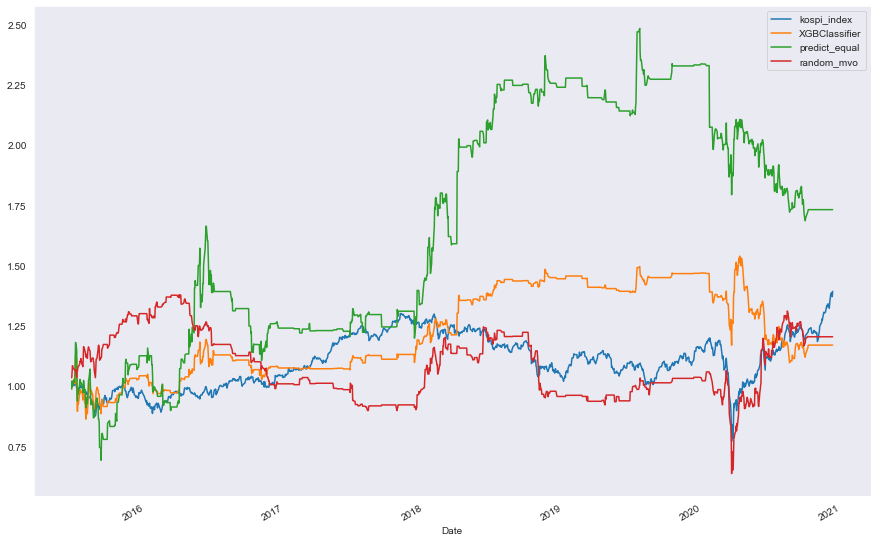

In [137]:
final_backtest = pd.DataFrame()
final_backtest['kospi_index'] = kospi_index['log_ret']
final_backtest[best_model_name] = np.nan
final_backtest.loc[datetime_list, best_model_name] = backtest_model[best_model_name]
final_backtest['predict_equal'] = np.nan
final_backtest['random_mvo'] = np.nan
final_backtest.loc[datetime_list, ['predict_equal', 'random_mvo']] = compare_backtest[['predict_equal', 'random_mvo']]
final_backtest = final_backtest[backtest_model.index[0]:].fillna(0)
final_backtest.iloc[0] = final_backtest.iloc[0] + 1
final_backtest.cumsum().plot(figsize = (15,10))

In [138]:
stat_df.resample('1Y').mean()

,select_num,MyScore,accuracy,precision,recall,f1_score,sensitivity,specificity
Date,,,,,,,,
2015-12-31,2.686567,0.393745,0.625770,0.475956,0.023385,0.065305,0.023385,0.982804
2016-12-31,0.776423,0.366000,0.640486,0.456311,0.006228,0.028284,0.006228,0.994921
2017-12-31,0.230453,0.263392,0.642925,0.341270,0.001774,0.019622,0.001774,0.998252
2018-12-31,0.491803,0.351177,0.640777,0.464080,0.004550,0.024396,0.004550,0.996917
2019-12-31,0.268293,0.268326,0.657570,0.333949,0.002529,0.027071,0.002529,0.998279
2020-12-31,7.342246,0.343336,0.625781,0.386473,0.064631,0.095469,0.064631,0.947292


In [141]:
stat_df.resample('1Y').sum()

,select_num,MyScore,accuracy,precision,recall,f1_score,sensitivity,specificity
Date,,,,,,,,
2015-12-31,360.0,32.287093,83.853147,39.028376,3.133637,5.355016,3.133637,131.695701
2016-12-31,191.0,37.697956,157.559441,47.000000,1.525843,2.884930,1.525843,244.750620
2017-12-31,56.0,11.062454,156.230769,14.333333,0.431009,0.824126,0.431009,242.575179
2018-12-31,120.0,30.552416,156.349650,40.375000,1.110259,2.122457,1.110259,243.247745
2019-12-31,66.0,11.001362,161.762238,13.691919,0.622084,1.109918,0.622084,245.576617
2020-12-31,1373.0,54.590361,117.020979,61.449169,12.086017,15.179572,12.086017,177.143553


### 돌려 두었던 자료들

,select_num,MyScore,accuracy,precision,recall,f1_score,sensitivity,specificity
Date,,,,,,,,
2020-01-31,0.142857,0.000000,0.727655,0.000000,0.000000,0.000000,0.000000,0.999077
2020-02-29,0.150000,0.000000,0.714973,0.000000,0.000000,0.000000,0.000000,0.999054
2020-03-31,10.954545,0.263894,0.599903,0.416787,0.057651,0.126987,0.057651,0.937049
2020-04-30,4.250000,0.385836,0.513102,0.535145,0.022267,0.047673,0.022267,0.972604
2020-05-31,1.052632,0.209075,0.555868,0.266667,0.004024,0.014578,0.004024,0.992737
2020-06-30,3.318182,0.249866,0.629315,0.305714,0.015979,0.032048,0.015979,0.980785
2020-07-31,1.304348,0.237652,0.627993,0.308824,0.005232,0.013686,0.005232,0.992116
2020-08-31,1.250000,0.220237,0.560963,0.328571,0.005973,0.022585,0.005973,0.992830
2020-09-30,1.333333,0.254064,0.649351,0.267857,0.006934,0.019765,0.006934,0.992024


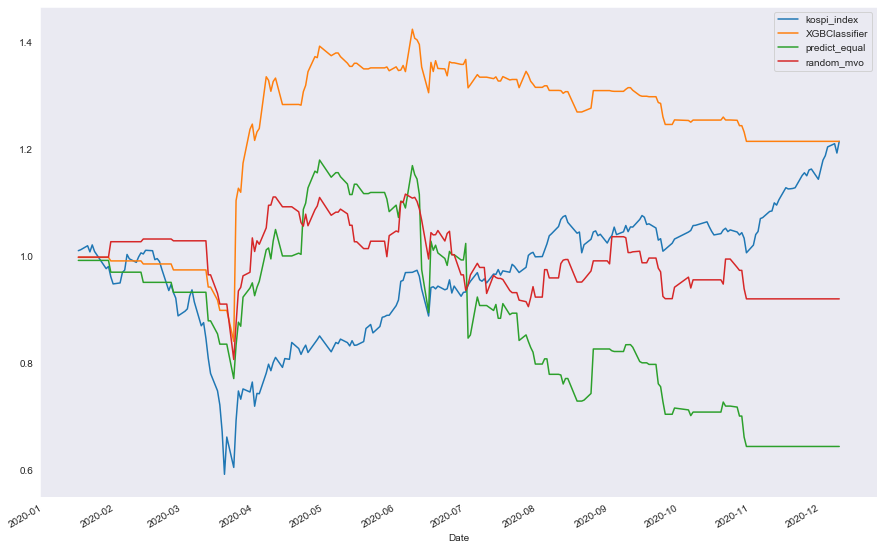

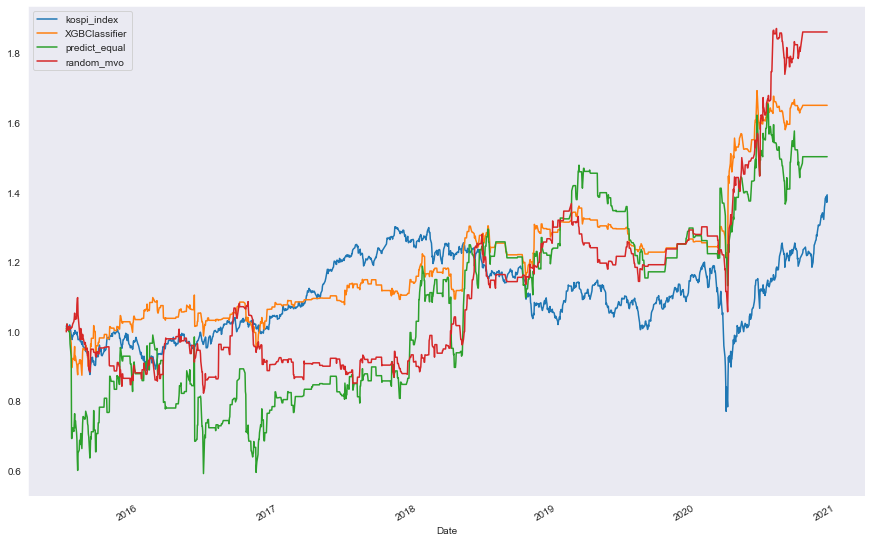

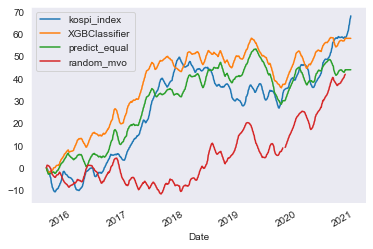

In [108]:
(final_backtest.rolling(20).mean() / final_backtest.rolling(20).std()).cumsum().plot()

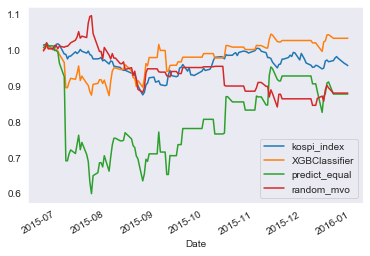

In [90]:
final_backtest[final_backtest.index < '2015-12-31'].cumsum().plot()

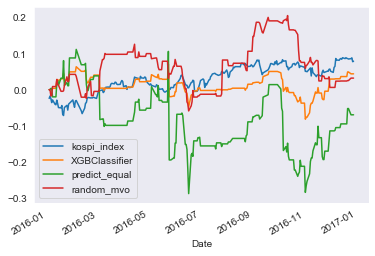

In [95]:
final_backtest[(final_backtest.index > '2016-01-01') & (final_backtest.index < '2016-12-31')].cumsum().plot()

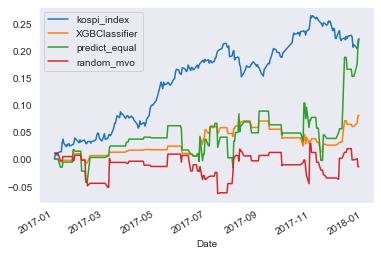

In [97]:
final_backtest[(final_backtest.index > '2017-01-01') & (final_backtest.index < '2017-12-31')].cumsum().plot()

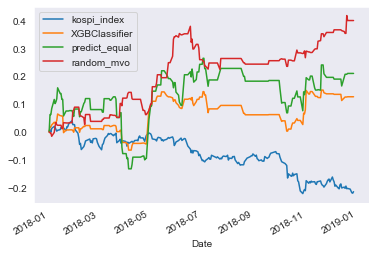

In [98]:
final_backtest[(final_backtest.index > '2018-01-01') & (final_backtest.index < '2018-12-31')].cumsum().plot()

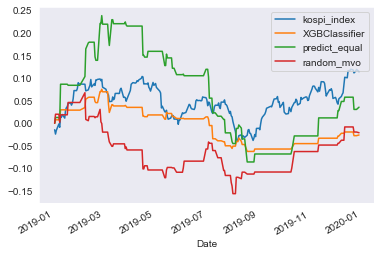

In [99]:
final_backtest[(final_backtest.index > '2019-01-01') & (final_backtest.index < '2019-12-31')].cumsum().plot()

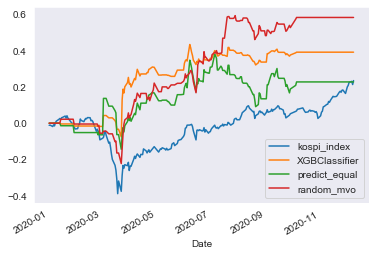

In [100]:
final_backtest[(final_backtest.index > '2020-01-01') & (final_backtest.index < '2020-12-31')].cumsum().plot()